In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab
%matplotlib inline
import os
import math
import time
import tensorflow as tf
from datasets import dataset_utils,cifar10
from tensorflow.contrib import slim

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
dropout_keep_prob=0.8
image_size = 32
step=20000
learning_rate=0.0002
train_dir = '/tmp/cifar10/swish7'

In [3]:
cifar10_data_dir='/media/ramdisk/data/cifar10'

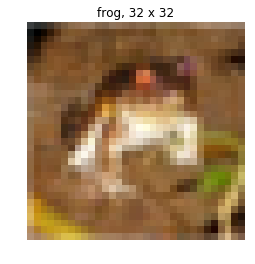

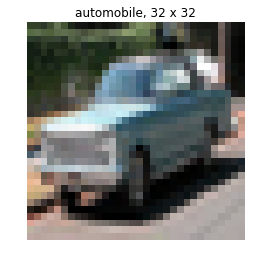

In [4]:
display_step=2

with tf.Graph().as_default(): 
    dataset = cifar10.get_split('train', cifar10_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])

    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(display_step):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()


In [7]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

def swish(features):
  # pylint: disable=g-doc-args
  """Computes the Swish activation function: `x * sigmoid(x)`.
  Source: "Searching for Activation Functions" (Ramachandran et al. 2017)
  https://arxiv.org/abs/1710.05941
  Args:
    features: A `Tensor` representing preactivation values.
    name: A name for the operation (optional).
  Returns:
    The activation value.
  """
  # pylint: enable=g-doc-args
  features = ops.convert_to_tensor(features, name="features")
  return features * math_ops.sigmoid(features)

def cnn_swish(images, num_classes, is_training):
    #https://github.com/agrawalnishant/tensorflow-1/tree/master/tensorflow/contrib/slim 
    ##vgg와  cifarndet을 참조함
    with slim.arg_scope([slim.max_pool2d], stride=2): 

        net = slim.repeat(images, 2, slim.conv2d, 64, [3, 3], scope='conv1',activation_fn=swish)
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2',activation_fn=swish)
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3',activation_fn=swish)
        net = slim.max_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4',activation_fn=swish)
        net = slim.max_pool2d(net, [2, 2], scope='pool4')
       
        net = slim.conv2d(net, 512, [2, 2], padding="VALID", scope='fc6')
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                         scope='dropout6')
        net = slim.conv2d(net, 512, [1, 1], scope='fc8', activation_fn=None)
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                           scope='dropout7')
        net = slim.conv2d(net, num_classes, [1, 1],
                          activation_fn=None,
                          normalizer_fn=None,
                          scope='fc9')
        
        net = tf.squeeze(net, [1,2],name='fc9/squeezed')
        
        return net

In [8]:
from preprocessing import cifarnet_preprocessing

def load_batch(dataset, batch_size=128, height=image_size, width=image_size, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=128,
        common_queue_min=32)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = cifarnet_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=4,
          capacity=4 * batch_size)
    
    return images, images_raw, labels

In [9]:
%%time
# This might take a few minutes.

print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = cifar10.get_split('train', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
  

    logits =cnn_swish(images, num_classes=dataset.num_classes, is_training=True)
 

    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()
    

    tf.summary.scalar('losses/Total Loss', total_loss)
    

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = slim.learning.create_train_op(total_loss, optimizer)


    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=step, 
          log_every_n_steps=10,
        save_interval_secs=100,
      save_summaries_secs=100)
  
    print('Finished training. Final batch loss %d' % final_loss)

Will save model to /tmp/cifar10/swish7
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/swish7/model.ckpt
INFO:tensorflow:

INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/swish7/model.ckpt
INFO:tensorflow:global_step/sec: 8.35014
INFO:tensorflow:Recording summary at step 834.
INFO:tensorflow:global step 840: loss = 1.0456 (0.115 sec/step)
INFO:tensorflow:global step 850: loss = 1.2034 (0.106 sec/step)
INFO:tensorflow:global step 860: loss = 1.4059 (0.118 sec/step)
INFO:tensorflow:global step 870: loss = 1.1157 (0.134 sec/step)
INFO:tensorflow:global step 880: loss = 1.2148 (0.120 sec/step)
INFO:tensorflow:global step 890: loss = 1.2053 (0.112 sec/step)
INFO:tensorflow:global step 900: loss = 1.2071 (0.116 sec/step)
INFO:tensorflow:global step 910: loss = 1.0786 (0.121 sec/step)
INFO:tensorflow:global step 920: loss = 1.2359 (0.115 sec/step)
INFO:tensorflow:global step 930: loss = 0.8541 (0.122 sec/step)
INFO:tensorflow:global step 940: loss = 1.0324 (0.106 sec/step)
INFO:tensorflow:global step 950: loss = 1.1717 (0.116 sec/step)
INFO:tensorflow:global step 960: loss = 1.2015 (0.122 sec/step)
INFO:te

INFO:tensorflow:global step 2060: loss = 0.9672 (0.112 sec/step)
INFO:tensorflow:global step 2070: loss = 0.7489 (0.125 sec/step)
INFO:tensorflow:global step 2080: loss = 0.8002 (0.112 sec/step)
INFO:tensorflow:global step 2090: loss = 0.6888 (0.117 sec/step)
INFO:tensorflow:global step 2100: loss = 0.7963 (0.109 sec/step)
INFO:tensorflow:global step 2110: loss = 0.8354 (0.129 sec/step)
INFO:tensorflow:global step 2120: loss = 0.7314 (0.107 sec/step)
INFO:tensorflow:global step 2130: loss = 0.7808 (0.126 sec/step)
INFO:tensorflow:global step 2140: loss = 0.6504 (0.115 sec/step)
INFO:tensorflow:global step 2150: loss = 0.7763 (0.131 sec/step)
INFO:tensorflow:global step 2160: loss = 0.7423 (0.130 sec/step)
INFO:tensorflow:global step 2170: loss = 0.6771 (0.116 sec/step)
INFO:tensorflow:global step 2180: loss = 0.7662 (0.104 sec/step)
INFO:tensorflow:global step 2190: loss = 0.8328 (0.115 sec/step)
INFO:tensorflow:global step 2200: loss = 0.5889 (0.109 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3300: loss = 0.5653 (0.117 sec/step)
INFO:tensorflow:global step 3310: loss = 0.5319 (0.113 sec/step)
INFO:tensorflow:global step 3320: loss = 0.5493 (0.121 sec/step)
INFO:tensorflow:global step 3330: loss = 0.3624 (0.116 sec/step)
INFO:tensorflow:global step 3340: loss = 0.5514 (0.132 sec/step)
INFO:tensorflow:global step 3350: loss = 0.5978 (0.111 sec/step)
INFO:tensorflow:global step 3360: loss = 0.5650 (0.114 sec/step)
INFO:tensorflow:global step 3370: loss = 0.6011 (0.129 sec/step)
INFO:tensorflow:global step 3380: loss = 0.5480 (0.121 sec/step)
INFO:tensorflow:global step 3390: loss = 0.5354 (0.108 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/swish7/model.ckpt
INFO:tensorflow:global_step/sec: 8.54999
INFO:tensorflow:Recording summary at step 3392.
INFO:tensorflow:global step 3400: loss = 0.6448 (0.117 sec/step)
INFO:tensorflow:global step 3410: loss = 0.5735 (0.116 sec/step)
INFO:tensorflow:global step 3420: loss = 0.6832 (0.113 sec

INFO:tensorflow:global step 4520: loss = 0.3004 (0.115 sec/step)
INFO:tensorflow:global step 4530: loss = 0.5434 (0.108 sec/step)
INFO:tensorflow:global step 4540: loss = 0.4543 (0.119 sec/step)
INFO:tensorflow:global step 4550: loss = 0.3433 (0.112 sec/step)
INFO:tensorflow:global step 4560: loss = 0.3411 (0.136 sec/step)
INFO:tensorflow:global step 4570: loss = 0.3299 (0.120 sec/step)
INFO:tensorflow:global step 4580: loss = 0.3174 (0.110 sec/step)
INFO:tensorflow:global step 4590: loss = 0.3582 (0.108 sec/step)
INFO:tensorflow:global step 4600: loss = 0.3641 (0.114 sec/step)
INFO:tensorflow:global step 4610: loss = 0.3296 (0.126 sec/step)
INFO:tensorflow:global step 4620: loss = 0.2696 (0.105 sec/step)
INFO:tensorflow:global step 4630: loss = 0.3442 (0.113 sec/step)
INFO:tensorflow:global step 4640: loss = 0.2647 (0.125 sec/step)
INFO:tensorflow:global step 4650: loss = 0.3816 (0.116 sec/step)
INFO:tensorflow:global step 4660: loss = 0.2925 (0.117 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5760: loss = 0.2627 (0.118 sec/step)
INFO:tensorflow:global step 5770: loss = 0.3747 (0.121 sec/step)
INFO:tensorflow:global step 5780: loss = 0.3169 (0.113 sec/step)
INFO:tensorflow:global step 5790: loss = 0.3212 (0.112 sec/step)
INFO:tensorflow:global step 5800: loss = 0.2781 (0.115 sec/step)
INFO:tensorflow:global step 5810: loss = 0.1569 (0.111 sec/step)
INFO:tensorflow:global step 5820: loss = 0.2720 (0.105 sec/step)
INFO:tensorflow:global step 5830: loss = 0.2810 (0.116 sec/step)
INFO:tensorflow:global step 5840: loss = 0.2440 (0.118 sec/step)
INFO:tensorflow:global step 5850: loss = 0.2750 (0.123 sec/step)
INFO:tensorflow:global step 5860: loss = 0.3577 (0.106 sec/step)
INFO:tensorflow:global step 5870: loss = 0.2104 (0.111 sec/step)
INFO:tensorflow:global step 5880: loss = 0.2472 (0.113 sec/step)
INFO:tensorflow:global step 5890: loss = 0.3502 (0.110 sec/step)
INFO:tensorflow:global step 5900: loss = 0.2595 (0.128 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6980: loss = 0.2130 (0.119 sec/step)
INFO:tensorflow:global step 6990: loss = 0.1933 (0.121 sec/step)
INFO:tensorflow:global step 7000: loss = 0.0927 (0.108 sec/step)
INFO:tensorflow:global step 7010: loss = 0.2333 (0.111 sec/step)
INFO:tensorflow:global step 7020: loss = 0.1834 (0.107 sec/step)
INFO:tensorflow:global step 7030: loss = 0.1032 (0.117 sec/step)
INFO:tensorflow:global step 7040: loss = 0.1815 (0.111 sec/step)
INFO:tensorflow:global step 7050: loss = 0.2611 (0.112 sec/step)
INFO:tensorflow:global step 7060: loss = 0.2277 (0.112 sec/step)
INFO:tensorflow:global step 7070: loss = 0.1847 (0.112 sec/step)
INFO:tensorflow:global step 7080: loss = 0.1472 (0.106 sec/step)
INFO:tensorflow:global step 7090: loss = 0.2659 (0.125 sec/step)
INFO:tensorflow:global step 7100: loss = 0.0794 (0.117 sec/step)
INFO:tensorflow:global step 7110: loss = 0.2353 (0.110 sec/step)
INFO:tensorflow:global step 7120: loss = 0.1598 (0.119 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8220: loss = 0.2132 (0.112 sec/step)
INFO:tensorflow:global step 8230: loss = 0.0791 (0.111 sec/step)
INFO:tensorflow:global step 8240: loss = 0.1285 (0.121 sec/step)
INFO:tensorflow:global step 8250: loss = 0.0784 (0.122 sec/step)
INFO:tensorflow:global step 8260: loss = 0.1149 (0.115 sec/step)
INFO:tensorflow:global step 8270: loss = 0.1369 (0.104 sec/step)
INFO:tensorflow:global step 8280: loss = 0.0901 (0.112 sec/step)
INFO:tensorflow:global step 8290: loss = 0.1191 (0.113 sec/step)
INFO:tensorflow:global step 8300: loss = 0.2131 (0.116 sec/step)
INFO:tensorflow:global step 8310: loss = 0.1739 (0.111 sec/step)
INFO:tensorflow:global step 8320: loss = 0.2256 (0.107 sec/step)
INFO:tensorflow:global step 8330: loss = 0.1541 (0.118 sec/step)
INFO:tensorflow:global step 8340: loss = 0.1451 (0.103 sec/step)
INFO:tensorflow:global step 8350: loss = 0.1711 (0.113 sec/step)
INFO:tensorflow:global step 8360: loss = 0.1276 (0.109 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9450: loss = 0.0879 (0.122 sec/step)
INFO:tensorflow:global step 9460: loss = 0.3064 (0.123 sec/step)
INFO:tensorflow:global step 9470: loss = 0.1409 (0.120 sec/step)
INFO:tensorflow:global step 9480: loss = 0.1066 (0.126 sec/step)
INFO:tensorflow:global step 9490: loss = 0.0330 (0.113 sec/step)
INFO:tensorflow:global step 9500: loss = 0.1282 (0.108 sec/step)
INFO:tensorflow:global step 9510: loss = 0.0747 (0.124 sec/step)
INFO:tensorflow:global step 9520: loss = 0.1800 (0.127 sec/step)
INFO:tensorflow:global step 9530: loss = 0.1472 (0.105 sec/step)
INFO:tensorflow:global step 9540: loss = 0.1072 (0.103 sec/step)
INFO:tensorflow:global step 9550: loss = 0.1865 (0.104 sec/step)
INFO:tensorflow:global step 9560: loss = 0.0912 (0.112 sec/step)
INFO:tensorflow:global step 9570: loss = 0.0988 (0.120 sec/step)
INFO:tensorflow:global step 9580: loss = 0.0716 (0.110 sec/step)
INFO:tensorflow:global step 9590: loss = 0.0403 (0.111 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 10690: loss = 0.0224 (0.109 sec/step)
INFO:tensorflow:global step 10700: loss = 0.1066 (0.112 sec/step)
INFO:tensorflow:global step 10710: loss = 0.1411 (0.105 sec/step)
INFO:tensorflow:global step 10720: loss = 0.1250 (0.109 sec/step)
INFO:tensorflow:global step 10730: loss = 0.0983 (0.106 sec/step)
INFO:tensorflow:global step 10740: loss = 0.0914 (0.127 sec/step)
INFO:tensorflow:global step 10750: loss = 0.1110 (0.117 sec/step)
INFO:tensorflow:global step 10760: loss = 0.2838 (0.116 sec/step)
INFO:tensorflow:global step 10770: loss = 0.0730 (0.126 sec/step)
INFO:tensorflow:global step 10780: loss = 0.1918 (0.122 sec/step)
INFO:tensorflow:global step 10790: loss = 0.0558 (0.111 sec/step)
INFO:tensorflow:global step 10800: loss = 0.0806 (0.117 sec/step)
INFO:tensorflow:global step 10810: loss = 0.0948 (0.113 sec/step)
INFO:tensorflow:global step 10820: loss = 0.0960 (0.115 sec/step)
INFO:tensorflow:global step 10830: loss = 0.0703 (0.115 sec/step)
INFO:tenso

INFO:tensorflow:global step 11920: loss = 0.0851 (0.113 sec/step)
INFO:tensorflow:global step 11930: loss = 0.0715 (0.123 sec/step)
INFO:tensorflow:global step 11940: loss = 0.0340 (0.119 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/swish7/model.ckpt
INFO:tensorflow:Recording summary at step 11946.
INFO:tensorflow:global step 11950: loss = 0.0945 (0.115 sec/step)
INFO:tensorflow:global step 11960: loss = 0.0547 (0.119 sec/step)
INFO:tensorflow:global step 11970: loss = 0.1869 (0.126 sec/step)
INFO:tensorflow:global step 11980: loss = 0.0661 (0.109 sec/step)
INFO:tensorflow:global step 11990: loss = 0.0311 (0.112 sec/step)
INFO:tensorflow:global step 12000: loss = 0.0762 (0.119 sec/step)
INFO:tensorflow:global step 12010: loss = 0.0282 (0.109 sec/step)
INFO:tensorflow:global step 12020: loss = 0.1021 (0.114 sec/step)
INFO:tensorflow:global step 12030: loss = 0.1054 (0.117 sec/step)
INFO:tensorflow:global step 12040: loss = 0.0339 (0.126 sec/step)
INFO:tensorflow:glob

INFO:tensorflow:global step 13130: loss = 0.0383 (0.109 sec/step)
INFO:tensorflow:global step 13140: loss = 0.1907 (0.119 sec/step)
INFO:tensorflow:global step 13150: loss = 0.1536 (0.112 sec/step)
INFO:tensorflow:global step 13160: loss = 0.0313 (0.117 sec/step)
INFO:tensorflow:global step 13170: loss = 0.0169 (0.112 sec/step)
INFO:tensorflow:global step 13180: loss = 0.0629 (0.120 sec/step)
INFO:tensorflow:global step 13190: loss = 0.1768 (0.114 sec/step)
INFO:tensorflow:global step 13200: loss = 0.1154 (0.128 sec/step)
INFO:tensorflow:global step 13210: loss = 0.0434 (0.111 sec/step)
INFO:tensorflow:global step 13220: loss = 0.0473 (0.114 sec/step)
INFO:tensorflow:global step 13230: loss = 0.1071 (0.110 sec/step)
INFO:tensorflow:global step 13240: loss = 0.0139 (0.115 sec/step)
INFO:tensorflow:global step 13250: loss = 0.0794 (0.118 sec/step)
INFO:tensorflow:global step 13260: loss = 0.0501 (0.108 sec/step)
INFO:tensorflow:global step 13270: loss = 0.1043 (0.120 sec/step)
INFO:tenso

INFO:tensorflow:global step 14360: loss = 0.0362 (0.117 sec/step)
INFO:tensorflow:global step 14370: loss = 0.0614 (0.114 sec/step)
INFO:tensorflow:global step 14380: loss = 0.0281 (0.107 sec/step)
INFO:tensorflow:global step 14390: loss = 0.0575 (0.134 sec/step)
INFO:tensorflow:global step 14400: loss = 0.0938 (0.109 sec/step)
INFO:tensorflow:global step 14410: loss = 0.0275 (0.112 sec/step)
INFO:tensorflow:global step 14420: loss = 0.1118 (0.111 sec/step)
INFO:tensorflow:global step 14430: loss = 0.0604 (0.117 sec/step)
INFO:tensorflow:global step 14440: loss = 0.0284 (0.132 sec/step)
INFO:tensorflow:global step 14450: loss = 0.0043 (0.116 sec/step)
INFO:tensorflow:global step 14460: loss = 0.0345 (0.110 sec/step)
INFO:tensorflow:global step 14470: loss = 0.0486 (0.116 sec/step)
INFO:tensorflow:global step 14480: loss = 0.0553 (0.112 sec/step)
INFO:tensorflow:global step 14490: loss = 0.0372 (0.109 sec/step)
INFO:tensorflow:global step 14500: loss = 0.0267 (0.122 sec/step)
INFO:tenso

INFO:tensorflow:global step 15570: loss = 0.0328 (0.128 sec/step)
INFO:tensorflow:global step 15580: loss = 0.0669 (0.105 sec/step)
INFO:tensorflow:global step 15590: loss = 0.0634 (0.114 sec/step)
INFO:tensorflow:global step 15600: loss = 0.0441 (0.116 sec/step)
INFO:tensorflow:global step 15610: loss = 0.0084 (0.109 sec/step)
INFO:tensorflow:global step 15620: loss = 0.0538 (0.107 sec/step)
INFO:tensorflow:global step 15630: loss = 0.1924 (0.117 sec/step)
INFO:tensorflow:global step 15640: loss = 0.0561 (0.111 sec/step)
INFO:tensorflow:global step 15650: loss = 0.0327 (0.116 sec/step)
INFO:tensorflow:global step 15660: loss = 0.0774 (0.119 sec/step)
INFO:tensorflow:global step 15670: loss = 0.0814 (0.109 sec/step)
INFO:tensorflow:global step 15680: loss = 0.0377 (0.118 sec/step)
INFO:tensorflow:global step 15690: loss = 0.0471 (0.111 sec/step)
INFO:tensorflow:global step 15700: loss = 0.0634 (0.113 sec/step)
INFO:tensorflow:global step 15710: loss = 0.1148 (0.111 sec/step)
INFO:tenso

INFO:tensorflow:global step 16800: loss = 0.0546 (0.117 sec/step)
INFO:tensorflow:global step 16810: loss = 0.0438 (0.109 sec/step)
INFO:tensorflow:global step 16820: loss = 0.0613 (0.126 sec/step)
INFO:tensorflow:global step 16830: loss = 0.0350 (0.116 sec/step)
INFO:tensorflow:global step 16840: loss = 0.0656 (0.112 sec/step)
INFO:tensorflow:global step 16850: loss = 0.0225 (0.115 sec/step)
INFO:tensorflow:global step 16860: loss = 0.0664 (0.105 sec/step)
INFO:tensorflow:global step 16870: loss = 0.0821 (0.104 sec/step)
INFO:tensorflow:global step 16880: loss = 0.0730 (0.114 sec/step)
INFO:tensorflow:global step 16890: loss = 0.0306 (0.111 sec/step)
INFO:tensorflow:global step 16900: loss = 0.0489 (0.133 sec/step)
INFO:tensorflow:global step 16910: loss = 0.0623 (0.109 sec/step)
INFO:tensorflow:global step 16920: loss = 0.0336 (0.109 sec/step)
INFO:tensorflow:global step 16930: loss = 0.0574 (0.119 sec/step)
INFO:tensorflow:global step 16940: loss = 0.0318 (0.114 sec/step)
INFO:tenso

INFO:tensorflow:global step 18010: loss = 0.0267 (0.112 sec/step)
INFO:tensorflow:global step 18020: loss = 0.0125 (0.123 sec/step)
INFO:tensorflow:global step 18030: loss = 0.0524 (0.121 sec/step)
INFO:tensorflow:global step 18040: loss = 0.0315 (0.108 sec/step)
INFO:tensorflow:global step 18050: loss = 0.0400 (0.116 sec/step)
INFO:tensorflow:global step 18060: loss = 0.0270 (0.126 sec/step)
INFO:tensorflow:global step 18070: loss = 0.0852 (0.107 sec/step)
INFO:tensorflow:global step 18080: loss = 0.0324 (0.114 sec/step)
INFO:tensorflow:global step 18090: loss = 0.0745 (0.112 sec/step)
INFO:tensorflow:global step 18100: loss = 0.0199 (0.119 sec/step)
INFO:tensorflow:global step 18110: loss = 0.0192 (0.118 sec/step)
INFO:tensorflow:global step 18120: loss = 0.0458 (0.112 sec/step)
INFO:tensorflow:global step 18130: loss = 0.0577 (0.120 sec/step)
INFO:tensorflow:global step 18140: loss = 0.0902 (0.113 sec/step)
INFO:tensorflow:global step 18150: loss = 0.0160 (0.113 sec/step)
INFO:tenso

INFO:tensorflow:global step 19240: loss = 0.0727 (0.125 sec/step)
INFO:tensorflow:global step 19250: loss = 0.0288 (0.115 sec/step)
INFO:tensorflow:global step 19260: loss = 0.0547 (0.113 sec/step)
INFO:tensorflow:global step 19270: loss = 0.1185 (0.133 sec/step)
INFO:tensorflow:global step 19280: loss = 0.0512 (0.107 sec/step)
INFO:tensorflow:global step 19290: loss = 0.0562 (0.112 sec/step)
INFO:tensorflow:global step 19300: loss = 0.0921 (0.118 sec/step)
INFO:tensorflow:global step 19310: loss = 0.0574 (0.121 sec/step)
INFO:tensorflow:global step 19320: loss = 0.0300 (0.109 sec/step)
INFO:tensorflow:global step 19330: loss = 0.0451 (0.115 sec/step)
INFO:tensorflow:global step 19340: loss = 0.0647 (0.105 sec/step)
INFO:tensorflow:global step 19350: loss = 0.0216 (0.125 sec/step)
INFO:tensorflow:global step 19360: loss = 0.0636 (0.115 sec/step)
INFO:tensorflow:global step 19370: loss = 0.0110 (0.111 sec/step)
INFO:tensorflow:global step 19380: loss = 0.0513 (0.119 sec/step)
INFO:tenso

In [10]:
%%time


with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = cifar10.get_split('test', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = cnn_swish(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    

    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/mse':slim.metrics.streaming_mean_squared_error(predictions, labels),
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/TruePositives': slim.metrics.streaming_true_positives(predictions, labels),        
        'eval/TrueNegatives': slim.metrics.streaming_true_negatives(predictions, labels),
        'eval/FalsePositives': slim.metrics.streaming_false_positives(predictions, labels),
        'eval/FalseNegatives': slim.metrics.streaming_false_negatives(predictions, labels),
        'eval/Recall5': slim.metrics.streaming_sparse_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=list(names_to_updates.values()),
        final_op=list(names_to_values.values())
    )

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))


Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the inputs of labels and predictions have been switched.
Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2017-12-03-02:42:44
INFO:tensorflow:Restoring parameters from /tmp/cifar10/swish7/model.ckpt-20000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-03-02:42:45
eval/TrueNegatives: 10.000000
eval/FalsePositives: 2.000000
eval/mse: 2.835938
eval/Recall5: 0.968750
eval/FalseNegatives: 1.000000
eval/TruePositives: 115.000000
eval/Accuracy: 0.851562
CPU times: user 1.67 s, sys: 368 ms, total: 2.04 s
Wall time: 1.19 s


INFO:tensorflow:Restoring parameters from /tmp/cifar10/swish7/model.ckpt-20000


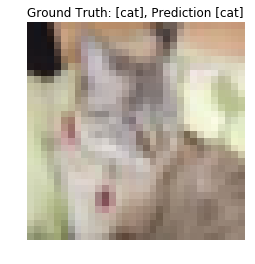

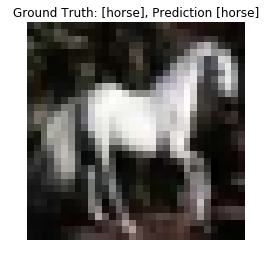

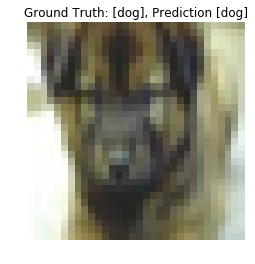

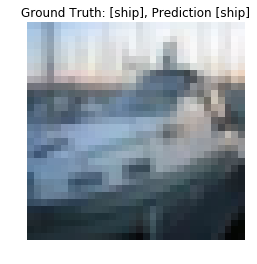

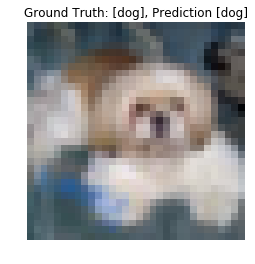

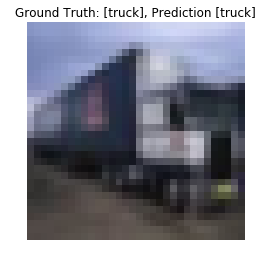

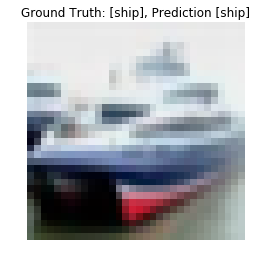

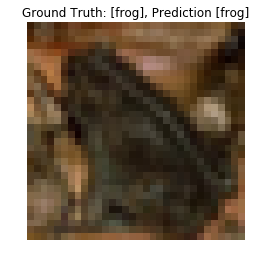

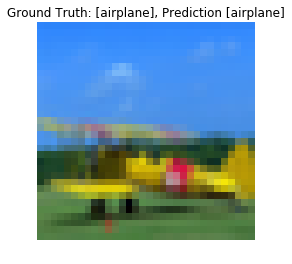

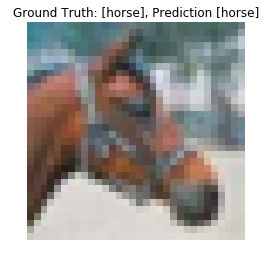

CPU times: user 3.18 s, sys: 1.76 s, total: 4.94 s
Wall time: 1.61 s


In [11]:
%%time
batch_size = 10
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cifar10.get_split('test',cifar10_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    logits = cnn_swish(images, num_classes=dataset.num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.local_variables_initializer())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()